# Машинное обучение
## ВМК МГУ, весна 2015/2016
## Лабораторная работа 1. Линейные модели

ФИО: Измаилов Павел Алексеевич

Группа: 317

####Используемая версия python: 3 

Данное задание посвящено применению линейных моделей в задачах классификации и регрессии. Вы научитесь:
* делать one-hot-кодирование категориальных признаков
* обучать логистическую и линейную регрессию
* отбирать признаки с помощью LASSO
* вычислять метрики качества классификации и регрессии
* выбирать лучший классификатор при ограничениях на точность или полноту
* калибровать вероятности
* реализовывать градиентный спуск (если захотите)


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Часть 1. Научные гранты в Австралии

![](http://imgur.com/cBdDBO3.jpg)

В данной части мы будем работать с задачей "Predict Grant Applications" (https://www.kaggle.com/c/unimelb/data), где для заявки на грант требуется предсказать, одобрят её или нет. Будем использовать лишь 40 признаков из имеющихся 249. Файлы для работы можно найти по ссылкам:
* https://db.tt/iYzRzQYP (обучение)
* https://db.tt/NGSHb5Qs (контроль)

#### Задание 1
Считайте обучающую и контрольную выборки из файлов с помощью pd.read_csv. Выделите целевую переменную (Grant.Status) в отдельный вектор.

In [7]:
data_train = pd.read_csv('data/unimel_train.csv')
data_test = pd.read_csv('data/unimel_test.csv')
y_train = np.array(data_train['Grant.Status'])
y_test = np.array(data_test['Grant.Status'])
del data_train['Grant.Status']
del data_test['Grant.Status']

#### Задание 2
В этом задании мы приведем данные к виду, пригодному для обучения линейных классификаторов. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду. Также надо устранить пропуски в данных.

В первую очередь поймем, зачем здесь нужно масштабирование. Нарисуем распределение трех признаков.

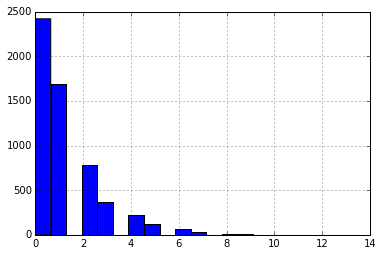

In [8]:
data_train['Number.of.Successful.Grant.1'].hist(bins=20)

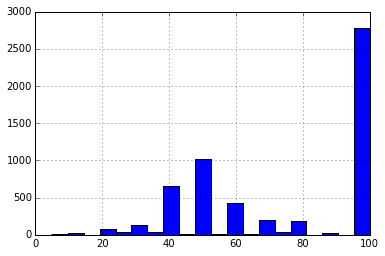

In [9]:
data_train['RFCD.Percentage.1'].hist(bins=20)

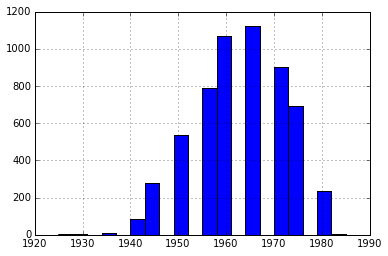

In [10]:
data_train['Year.of.Birth.1'].hist(bins=20)

Какую проблему вы наблюдаете на этих графиках? Как масштабирование поможет её исправить?

Выделенные признаки принимают значения в разных шкалах. Если их не нормализовать, то скорость сходимости градиентных методов оптимизации будет низкой.

В наших данных есть пропуски. Ответьте на вопросы:
1. Сколько всего пропущенных элементов в таблице с обучающей выборкой?
2. Сколько объектов имеют хотя бы один пропуск?
3. Сколько признаков имеют хотя бы одно пропущенное значение?

In [11]:
print('Всего пропусков в данных', data_train.isnull().sum().sum(), '.')
print('Объектов, имеющих хотя бы одно пропущенное значение', (data_train.isnull().sum(axis=1) > 0).sum(), '.')
print('Признаокв, имеющих хотя бы одно пропущенное значение', (data_train.isnull().sum(axis=0) > 0).sum(), '.')

Всего пропусков в данных 26843 .
Объектов, имеющих хотя бы одно пропущенное значение 5879 .
Признаокв, имеющих хотя бы одно пропущенное значение 38 .


Большинство признаков в нашем датасете являются категориальными. Типичным подходом к работе с ними является бинарное, или one-hot-кодирование (также есть подход со счётчиками, который мы уже применяли в прошлых работах). Для начала потренируемся делать бинарное кодирование на трех игрушечных объектах.

In [12]:
simple_data = pd.DataFrame({'City': ['Msk', 'SPb', 'Msk'], 'Weather': ['good', 'bad', 'worst']})
simple_data.head()

,City,Weather
0,Msk,good
1,SPb,bad
2,Msk,worst


In [13]:
# преобразуем каждый объект в dict
simple_data_dict = simple_data.T.to_dict().values()
print(simple_data_dict)

dict_values([{'City': 'Msk', 'Weather': 'good'}, {'City': 'SPb', 'Weather': 'bad'}, {'City': 'Msk', 'Weather': 'worst'}])


In [14]:
# делаем one-hot-кодирование
from sklearn.feature_extraction import DictVectorizer
transformer = DictVectorizer(sparse=False)
# примените здесь DictVectorizer к simple_data_dict, получите бинарную матрицу и выведите её
encoded_data = transformer.fit_transform(simple_data_dict)
print(encoded_data)

[[ 1.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.]
 [ 1.  0.  0.  0.  1.]]


Реализуйте функцию transform_data, которая принимает на вход DataFrame с признаками, объекты классов StandardScaler и DictVectorizer и булеву переменную is_test (True, если обрабатывает тестовую выборку и False, если обучающую). В функции должны выполняться следующие шаги:
1. Замена пропущенных значений на нули для вещественных признаков и на строки 'nan' для категориальных. Используйте для выполнения замены функцию fillna. Имена всех вещественных переменных перечислены в numeric_cols.
2. Масштабирование вещественных признаков с помощью StandardScaler (метод fit_transform, если is_test == False, и метод transform в противном случае).
3. One-hot-кодирование категориальных признаков с помощью DictVectorizer (метод fit_transform, если is_test == False, и метод transform в противном случае).

Метод должен возвращать tuple из трех элементов: преобразованной выборки, объекта StandardScaler и объекта DictVectorizer. Преобразованная выборка должна состоять из масштабированных вещественных признаков и закодированных категориальных (исходные признаки не должны в ней остаться).

In [15]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = data_train.columns.values.tolist()
categorical_cols = [col for col in categorical_cols if not(col in numeric_cols)]
example = data_train[categorical_cols].fillna('nan')
ex_dict = example.T.to_dict().values()

In [16]:
def transform_data(data, scaler, transformer, is_test, scale=True):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    categorical_cols = data.columns.values.tolist()
    categorical_cols = [col for col in categorical_cols if not(col in numeric_cols)]
    data[numeric_cols] = data[numeric_cols].fillna(0)
    data = data.fillna('nan')
    data[categorical_cols] = data[categorical_cols].astype(str)
    if is_test:
        if scale:
            new_features = scaler.transform(data[numeric_cols])
        else:
            new_features = data[numeric_cols]
        categorical_features = transformer.transform(data[categorical_cols].T.to_dict().values()).toarray()
        new_features = np.hstack((new_features, categorical_features))
    else:
        if scale:
            new_features = scaler.fit_transform(data[numeric_cols])
        else:
            new_features = data[numeric_cols]
        categorical_features = transformer.fit_transform(data[categorical_cols].T.to_dict().values()).toarray()
        new_features = np.hstack((new_features, categorical_features))
    return new_features, scaler, transformer
    

Применяем функцию к данным:

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformer = DictVectorizer()
X, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test, _, _ = transform_data(data_test, scaler, transformer, True)

Сколько признаков у вас получилось после преобразования?

In [18]:
print(X.shape[1])

11734


#### Задание 3
Подберите лучшее значение параметра регуляризации C для логистической регрессии с L2-регуляризатором (sklearn.linear_model.LogisticRegression) с помощью кросс-валидации по 5 блокам. В качестве метрики качества используйте AUC-ROC. Сетка для перебора указана ниже. По итогам кросс-валидации укажите лучшее значение параметра регуляризации. Обучите классификатор с этим параметром на всей обучающей выборке и найдите качество (AUC-ROC) на тестовой выборке.

In [19]:
from sklearn.cross_validation import KFold
cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=241)

In [20]:
# вам пригодятся функции cross_val_score или GridSearchCV; используйте в них объект cv в качестве генератора разбиений
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
logreg = LogisticRegression()
params = {'C': C_grid}
clf = GridSearchCV(logreg, params, scoring='roc_auc')
clf.fit(X, y_train)
best_estimator = clf.best_estimator_

print('Лучшее значение параметра регуляризации:', best_estimator.get_params()['C'])

best_estimator.fit(X, y_train)
predicted_y = best_estimator.predict_proba(X_test)[:, 1]
print('ROC-AUC на тестовой выборке: ', roc_auc_score(y_test, predicted_y))

Лучшее значение параметра регуляризации: 0.1
ROC-AUC на тестовой выборке:  0.880340804287


Попробуем теперь логистическую регрессию с L1-регуляризатором (penalty='l1'). Выведите число ненулевых коэффициентов (clf.coef\_) при каждом значении параметра регуляризации из сетки.

In [21]:
class ListTable(list):
    def _repr_html_(self):
        html = ["<table max-width=100%>"]
        for elem in self:
            html.append("<tr>")
            html.append("<td>{0}</td>".format(elem[0]))
            html.append("<td>{0}</td>".format(elem[1]))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
table = [('C', 'Число ненулевых коэффициентов')]
for C in C_grid:
    logreg = LogisticRegression(penalty='l1', C=C)
    logreg.fit(X, y_train)
    table.append((C, np.sum(logreg.coef_ != 0)))
ListTable(table)

C,Число ненулевых коэффициентов
0.001,0
0.01,9
0.1,58
1.0,667
10.0,2460
100.0,2870


Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01? Сколько для достижения такого качества ей нужно признаков?

In [22]:
logreg = LogisticRegression(penalty='l1', C=0.01)
logreg.fit(X, y_train)
predicted_y = logreg.predict_proba(X_test)[:, 1]
print('ROC-AUC на тестовой выборке: ', roc_auc_score(y_test, predicted_y))
print('Для получения такого качества оказалось достаточно 9 признаков.')

ROC-AUC на тестовой выборке:  0.852546744568
Для получения такого качества оказалось достаточно 9 признаков.


#### Задание 4
В этом задании мы внимательно рассмотрим различные аспекты качества классификатора. Для этого возьмите классификатор с L2-регуляризатором с лучшим значением параметра регуляризации (вы его нашли в предыдущем задании), обучите на полной обучающей выборке и найдите предсказания вероятностей на тесте. Далее будем работать только с этими прогнозами.

In [23]:
logreg = LogisticRegression(C=0.1)
logreg.fit(X, y_train)
predicted_y = best_estimator.predict_proba(X_test)[:, 1]

Посчитайте AUC-ROC, AUC-PR (average_precision_score) и log-loss для прогнозов.

In [24]:
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
table = [('ROC-AUC', roc_auc_score(y_test, predicted_y))]
table.append(('AUC-PR', average_precision_score(y_test, predicted_y)))
table.append(('Log-loss', log_loss(y_test, predicted_y)))
ListTable(table)

ROC-AUC,0.8803408042872678
AUC-PR,0.8387493987323461
Log-loss,0.4427420368281853


Нарисуйте ROC- и PR-кривые. Не забудьте подписать оси.

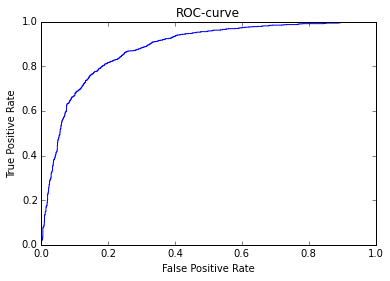

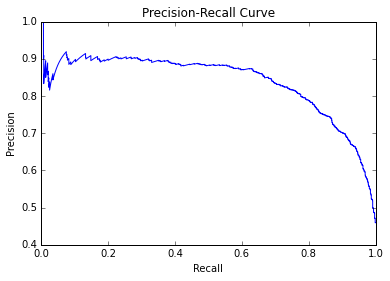

In [25]:
from sklearn.metrics import roc_curve, precision_recall_curve
fpr, tpr, thresholds_roc = roc_curve(y_test, predicted_y)
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-curve')
plt.show()
precision, recall, thresholds_pr = precision_recall_curve(y_test, predicted_y)
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve')
plt.show()

Допустим, мы хотим построить классификатор, который будет находить не менее 90% успешных грантов. Соответственно, имеем нижнюю границу 90% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога? Для получения ответа проанализируйте массивы, возвращаемые функцией metrics.precision_recall_curve.

In [26]:
print('Наибольшая возможная точность', precision[len(recall[recall > 0.9])], 'при данном ограничении на полноту')
print('достигается при пороге', thresholds_pr[len(recall[recall > 0.9])],  end="")
print('.')

Наибольшая возможная точность 0.701754385965 при данном ограничении на полноту
достигается при пороге 0.315451906769.


Возьмите классификатор с порогом из предыдущего пункта и подсчитайте для него F-меру. Почему она получилась маленькой, несмотря на высокую полноту?

In [27]:
opt_precision = precision[len(recall[recall > 0.9])]
opt_recall = recall[len(recall[recall > 0.9])]
F_measure = 2 * (opt_precision * opt_recall) / (opt_precision + opt_recall)
print('F-мера:', F_measure)
print('F-мера — гармоническое среднее полноты и точности. Так как точность при выбранном пороге')
print('низка (0.7), то и F-мера не слишком высока.')

F-мера: 0.788321167883
F-мера — гармоническое среднее полноты и точности. Так как точность при выбранном пороге
низка (0.7), то и F-мера не слишком высока.


Допустим, что университету важно подавать как можно меньше заявок, которые окажутся неуспешными — они очень плохо влияют на репутацию. Установим нижнюю границу на точность 80%. Какую максимальную полноту при этом можно обеспечить? При каком пороге?

In [28]:
print('Максимальная полнота ', recall[len(precision[precision > 0.8])], 'при данном ограничении на точность')
print('достигается при пороге', thresholds_pr[len(precision[precision > 0.8])],  end="")
print('.')

Максимальная полнота  0.8759367194 при данном ограничении на точность
достигается при пороге 0.359109087236.


#### Задание 5
В этом задании мы научимся оценивать способность классификатора предсказывать вероятности, а также разберемся с калибровкой.

Начнем с калибровочных кривых. Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [29]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.plot(bin_middle_points, bin_real_ratios)

Проверим её работу на логистической регрессии (поменяйте имена переменных, если это необходимо). Получилась ли почти диагональная калибровочная кривая?

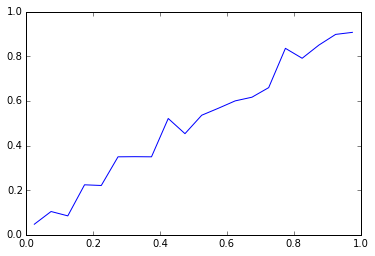

In [30]:
clf = LogisticRegression(C=1.0)
clf.fit(X, y_train)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

Заодно обратим внимание на то, как часто классификатор выдает те или иные вероятности.

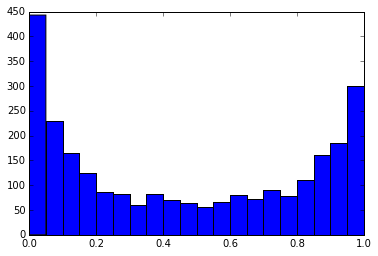

In [31]:
plt.hist(preds, bins=20)
plt.show()

Обучим теперь классификатор с кусочно-линейной функцией потерь (hinge loss, как в SVM).

In [32]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
clf.fit(X, y_train)
preds = clf.decision_function(X_test)
preds = 1.0 / (1.0 + np.exp(-preds))

Изучите распределение ответов классификатора. Чем оно отличается от распределения у логистической регрессии? Чем вы можете объяснить это?

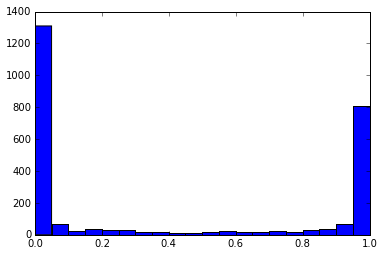

Распределение ответов отличается от распределения ответов для логисчтической регрессии.
Данный классификатор почти всегда выдает ответы близкие к 0 или к 1.
Это можно объяснить тем, что данный метод меньше штрафует за большую уверенность в неправильном
ответе, чем логистическая регрессия (потому что hinge loss меньше логистической функции при 
больших отрицательных значениях). Поэтому данный метод реже "сомневается" в своих предсказаниях.


In [33]:
plt.hist(preds, bins=20)
plt.show()
print('Распределение ответов отличается от распределения ответов для логисчтической регрессии.')
print('Данный классификатор почти всегда выдает ответы близкие к 0 или к 1.')
print('Это можно объяснить тем, что данный метод меньше штрафует за большую уверенность в неправильном')
print('ответе, чем логистическая регрессия (потому что hinge loss меньше логистической функции при ')
print('больших отрицательных значениях). Поэтому данный метод реже "сомневается" в своих предсказаниях.')

Нарисуем калибровочную кривую. Видите ли вы какие-либо проблемы в ней?

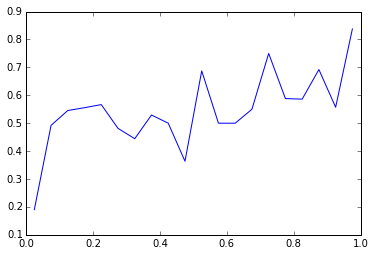

Калибровочная гривая сильно отличается от диагональной, имеет пилообразный вид.


In [34]:
plot_calibration_curve(y_test, preds)
plt.show()
print('Калибровочная гривая сильно отличается от диагональной, имеет пилообразный вид.')

Попробуем откалибровать вероятности. Грубо говоря, это процедура, которая для каждого отрезка $[a_i, b_i]$ строит преобразование, которое корректирует вероятности в нем, приводя тем самым калибровочную кривую к диагональной форме.

Воспользуйтесь классом sklearn.calibration.CalibratedClassifierCV для калибровки вероятностей на обучении, и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

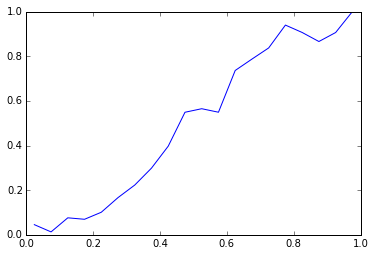

Калибровочная кривая улучшилась


In [35]:
from sklearn.calibration import CalibratedClassifierCV
clf = CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge'))
clf.fit(X, y_train)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)
plt.show()
print('Калибровочная кривая улучшилась')

#### Задание 6
Здесь вы можете вставить вашу любимую картинку про Австралию.

У меня сейчас нет интернета на ноутбуке — не могу найти картинку.

## Часть 2. Градиентный спуск своими руками
**(опциональная часть, за правильное выполнение к оценке добавляется 3 балла)**

В этой части вам предстоит самостоятельно реализовать градиентный спуск для логистической функции потерь — то есть, по сути, собственными руками обучить логистическую регрессию. Будем использовать данные из предыдущей части.

Добавьте к обучающей и тестовой выборкам единичный признак. Переведите значения целевого вектора в множество $\{-1, +1\}$.

In [36]:
X = np.hstack((X, np.ones((X.shape[0], 1))))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

Для начала реализуйте функции, которые вычисляют функционал, его градиент, а также прогнозы модели.

In [37]:
def sigmoid(arr):
    return 1 / (1 + np.exp(-arr))
# возвращает вектор предсказанных вероятностей для выборки X
def make_pred(X, w):
    pred = sigmoid(X.dot(w))
    return np.hstack((1 - pred, pred))

In [38]:
# возвращает значение логистического функционала для выборки (X, y) и вектора весов w
def get_func(w, X, y):
    Z = -y[:, None] * X
    return np.sum(np.log(1 + np.exp(Z.dot(w))), axis=0) / y.size

In [39]:
# возвращает градиент логистического функционала для выборки (X, y) и вектора весов w
def get_grad(w, X, y):
    Z = -y[:, None] * X
    anc_var = np.exp(-Z.dot(w))
    return np.sum(Z / (1 + anc_var), axis=0).reshape(w.shape) / y.size

Теперь реализуйте градиентный спуск (не стохастический). Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В градиентном спуске должно выполняться не более max_iter итераций.

In [40]:
from IPython.display import clear_output

def _linesearch_armiho(fun, point, gradient, step_0=1.0, theta=0.5, eps=1e-2,
                       direction=None, point_loss=None, maxstep=np.inf):
    """
    Одномерный поиск для выбора шага, основанный на правиле Армихо.
    fun — оптимизируемая функция
    point — текущее приближение метода
    direction — текущее направление оптимизации. По умолчанию равно антиградиенту.
    gradient — градиент в текущей точке
    step_0 — начальная длина шага
    theta, eps — параметры правила Армихо
    point_loss — значение оптимизируемой функции в текущем приближении метода
    Возвращает кортеж (new point, step) — новое приближение и длину шага
    """
    if point_loss is None:
        current_loss = fun(point)
    else:
        current_loss = point_loss
    if len(gradient.shape) == 2:
        gradient = gradient[:, 0]
    if direction is None:
        direction = -gradient

    step = step_0/theta
    new_point = point + step * direction.reshape(point.shape)
    while fun(new_point) > current_loss + eps * step * direction.dot(gradient):
        step *= theta
        new_point = point + step * direction.reshape(point.shape)
    return new_point, step

def grad_descent(X, y, step_size, max_iter):
    if step_size == 'armiho':
        step = 1.0
    np.random.seed(2)
#     w = np.random.normal(size=(X.shape[1], 1))/1000
    w = np.zeros((X.shape[1], 1))
    def loss_fun(point):
        return get_func(point, X, y)
    def grad_fun(point):
        return get_grad(point, X, y)
    loss_lst = []
    for i in range(max_iter):
        clear_output(wait=True)
        print('step size', step_size)
        print('Iteration ', i+1, '/', max_iter)
        loss = loss_fun(w)
        grad = grad_fun(w)
        loss_lst.append(loss)
        if step_size == 'armiho':
            w, step = _linesearch_armiho(fun=loss_fun, gradient=grad, point_loss=loss, point=w, step_0=step)
        else:
            w -= step_size * grad
    return w, loss_lst
    

Запустите градиентный спуск для значений размера шага из набора [0.001, 1, 10]. Нарисуйте кривые зависимости значения функционала от номера итерации. Проанализируйте их. Вычислите AUC-ROC на тестовой выборке для лучшего из обученных вариантов.

step size armiho
Iteration  20 / 20


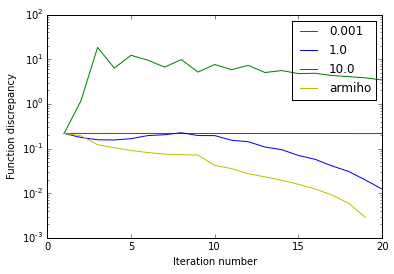

In [41]:
step_lst = [0.001, 1.0, 10.0, 'armiho']
color_lst = ['-r', '-b', '-g', '-y']
loss_lists = []
for step_size in step_lst:
    w, loss_lst = grad_descent(X, y_train, step_size, max_iter=20)
    loss_lists.append(loss_lst)

fun_min = loss_lists[0][0]
for loss_list in loss_lists:
    if min(loss_list) < fun_min:
        fun_min = min(loss_list)
for loss_list, clr, step_size in list(zip(loss_lists, color_lst, step_lst)):
    plt.semilogy(range(1, len(loss_lst) + 1), [loss - fun_min for loss in loss_list], clr, label=str(step_size))
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Function discrepancy')
plt.show()

In [42]:
w, loss_lst = grad_descent(X, y_train, 'armiho', max_iter=20)
predicted = make_pred(X_test, w)[:, 1]
print('ROC-AUC:', roc_auc_score(y_test, predicted))

step size armiho
Iteration  20 / 20
ROC-AUC: 0.856175389725


Теперь реализуйте стохастический градиентный спуск. Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В стохастическом градиентном спуске должно выполняться не более max_iter итераций.

In [43]:
def stoch_grad_approximation(w, X, y, i):
    Z = -y[i, None] * X[i, :]
    anc_var = np.exp(-Z.dot(w))
    return (Z / (1 + anc_var)).reshape(w.shape)

def sgd(X, y, step_size, max_iter):
    update_rate = 5
    step0 = step_size
    gamma = 0.5
    step = step0
    w = np.zeros((X.shape[1], 1))
    loss_lst = []

    for i in range(max_iter):
        clear_output(wait=True)
        print('Iteration ', i+1, '/', max_iter)
        loss_lst.append(get_func(w, X, y))
        index = np.random.randint(0, y.size - 1)
        gradient = stoch_grad_approximation(w, X, y, index)
        w = w - step * gradient
        if not (i % y.size) and i != 0:
            step = step0 / np.power(iteration_counter + 1, gamma)
    return w, loss_lst

Подберите размер шага, при котором SGD будет сходиться. Нарисуйте график сходимости. Вычислите AUC-ROC на тестовой выборке.

Iteration  100 / 100


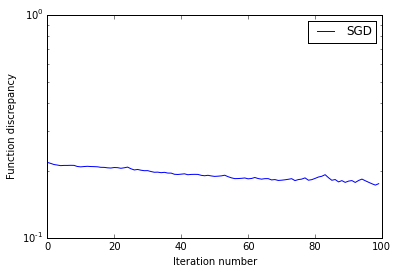

ROC-AUC: 0.728851134442


In [44]:
w, loss_lst = sgd(X, y_train, step_size=1e-2, max_iter=100)
plt.semilogy(range(len(loss_lst)), [loss - fun_min for loss in loss_lst], label='SGD')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Function discrepancy')
plt.show()

predicted = make_pred(X_test, w)[:, 1]
print('ROC-AUC:', roc_auc_score(y_test, predicted))

А теперь самое сложное: заново сформируйте выборку с помощью transform_data, но теперь не масштабируйте вещественные признаки. Запустите на этой выборке градиентный спуск. Что вы наблюдаете? Удается ли достичь такого же качества, как и при использовании масштабирования?

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformer = DictVectorizer()
X_noscale, scaler, transformer = transform_data(data_train, scaler, transformer, False, scale=False)
X_test_noscale, _, _ = transform_data(data_test, scaler, transformer, True, scale=False)
w, loss_lst = grad_descent(X_noscale, y_train, 'armiho', max_iter=100)
predicted = make_pred(X_test_noscale, w)[:, 1]
print('ROC-AUC:', roc_auc_score(y_test, predicted))
print('Несмотря на то, что методу было дано большее количество итераций, ')
print('чем в случае со шкалированными признаками, результат оказался хуже.')

step size armiho
Iteration  100 / 100
ROC-AUC: 0.512250178675
Несмотря на то, что методу было дано большее количество итераций, 
чем в случае со шкалированными признаками, результат оказался хуже.


Здесь вы можете поделиться своими мыслями по поводу этой части.

Я дополнительно реализовал градиентный спуск с правилом Армихо для выбора длины шага и использовал его в качестве лучшего варианта.

## Часть 3. Линейная регрессия на простом примере

В этой части мы очень кратко разберемся с линейной регрессией и измерением качества ее прогнозов. Будем использовать датасет diabetes.

In [46]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
data = datasets.load_diabetes()
X, X_test, y, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

Обучите линейную регрессию с L2-регуляризатором, подобрав лучшее значение параметра регуляризации на тестовой выборке. Используйте MSE в качестве тестовой выборки. При каком значении этого параметра достигается наилучшее качество?

In [47]:
from sklearn.linear_model import Ridge
alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
mse_lst = []
for alpha in alpha_grid:
    linreg = Ridge(alpha)
    linreg.fit(X, y)
    preds = linreg.predict(X_test)
    mse_lst.append(np.linalg.norm(preds - y_test)**2 / y_test.size)
print('Наименьшее MSE', np.min(mse_lst), 'достигается при alpha =', alpha_grid[np.argmin(mse_lst)])

Наименьшее MSE 3096.03015101 достигается при alpha = 0.1


Вычислите для лучшей из моделей RMSE и коэффициент детерминации (r2_score) на тестовой выборке. Что вы можете сказать о значении коэффицинта детерминации? Насколько данная модель близка к оптимальной?

In [48]:
from sklearn.metrics import r2_score
alpha = alpha_grid[np.argmin(mse_lst)]
linreg = Ridge(alpha)
linreg.fit(X, y)
preds = linreg.predict(X_test)
print('RMSE:', np.linalg.norm(preds - y_test) / np.sqrt(y_test.size))
print('Коэффициент детерминации:', r2_score(y_test, preds))
print('Полученный коэффициент детерминации показывает, что модель')
print('далека от хорошей, и ее предсказания лишь вдвое лучше, чем ')
print('модель, предсказывающая среднее значение по выборке для любого объекта.')

RMSE: 55.6419819113
Коэффициент детерминации: 0.417024184822
Полученный коэффициент детерминации показывает, что модель
далека от хорошей, и ее предсказания лишь вдвое лучше, чем 
модель, предсказывающая среднее значение по выборке для любого объекта.
